# Example: Let's Build a Regression Model of Housing Prices with Regularization and SVD
In this example, we'll develop a regression model to predict housing prices using multiple features. We'll explore different estimation methods, including traditional normal equations and Singular Value Decomposition (SVD), to understand their relative advantages in terms of numerical stability and handling multicollinearity.

> __Learning Objectives:__
> 
> By the end of this example, you will be able to:
> - **Apply OLS estimation** to real-world data by computing parameter estimates using the normal equations $\hat{\mathbf{\theta}} = (\mathbf{X}^{\top}\mathbf{X})^{-1}\mathbf{X}^{\top}\mathbf{y}$ and evaluating model performance on training and testing datasets.
> - **Quantify parameter uncertainty** through variance estimation, standard errors, and confidence intervals to determine which features are statistically significant predictors of housing prices.
> - **Interpret statistical inference results** to make data-driven decisions about model refinement, feature selection, and understanding the key factors that influence housing prices.

Let's get started!
___

## Setup, Data, and Prerequisites
First, we set up the computational environment by including the `Include.jl` file and loading any needed resources.

> The [`include(...)` command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, etc. For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

Let's set up our code environment:

In [1]:
include(joinpath(@__DIR__, "Include.jl")); # include the Include.jl file

In addition to standard Julia libraries, we'll also use [the `VLDataScienceMachineLearningPackage.jl` package](https://github.com/varnerlab/VLDataScienceMachineLearningPackage.jl). Check out [the documentation](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/) for more information on the functions, types, and data used in this material.

### Data
We will develop a model to estimate housing prices based on factors like house area, bedrooms, furnished status, nearness to the main road, etc. The dataset is small; however, its complexity arises because it has strong multicollinearity. 

> __Acknowledgement__
> 
> The housing dataset is adapted from [Kaggle](https://www.kaggle.com/datasets/yasserh/housing-prices-dataset?select=Housing.csv) and was originally used in:
>
> * Harrison, D. and Rubinfeld, D.L. (1978) Hedonic prices and the demand for clean air. J. Environ. Economics and Management 5, 81–102.
> * Belsley D.A., Kuh, E. and Welsch, R.E. (1980) Regression Diagnostics. Identifying Influential Data and Sources of Collinearity. New York: Wiley.

We've encoded [the `MyKaggleHousingPricesDataset()` helper function](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/data/#VLDataScienceMachineLearningPackage.MyKaggleHousingPricesDataset) which returns the housing dataset [as a `DataFrame` instance](https://dataframes.juliadata.org/stable/).

Let's save the raw (unwrangled) data in the `original_dataset::DataFrame` variable:

In [2]:
original_dataset = MyKaggleHousingPricesDataset() # load the *original* dataset

Row,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
,Int64,Int64,Int64,Int64,Int64,String3,String3,String3,String3,String3,Int64,String3,String15
1,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
2,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
3,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
4,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
5,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished
6,10850000,7500,3,3,1,yes,no,yes,no,yes,2,yes,semi-furnished
7,10150000,8580,4,3,4,yes,no,no,no,yes,2,yes,semi-furnished
8,10150000,16200,5,3,2,yes,no,no,no,no,0,no,unfurnished
9,9870000,8100,4,1,2,yes,yes,yes,no,yes,2,yes,furnished


Notice that we have several columns (features) that are categorical, i.e., `{furnished | unfurnished | semifurnished}` or `{yes | no}`. We must replace these values with numbers, e.g., `{0 | 1 | 2}`, etc.
 > __Transformation:__ We'll transform the categorical features (including changing types from a `String` to an `Int`) using [the `transform!(...)` method exported by the DataFrames.jl package](https://dataframes.juliadata.org/stable/lib/functions/#DataFrames.transform!). This is an advanced operation, so if this is unclear, please review the [DataFrames.jl documentation](https://dataframes.juliadata.org/stable/lib/functions/#DataFrames.transform!) for more information.

 We'll save the transformed dataset in the `treated_dataset::DataFrame` variable:

In [3]:
treated_dataset = let

    treated_dataset = copy(original_dataset);    
    transform!(treated_dataset, :mainroad => ByRow( x-> (x=="yes" ? 1 : -1)) => :t_mainroad);
    transform!(treated_dataset, :guestroom => ByRow( x-> (x=="yes" ? 1 : -1)) => :t_guestroom);
    transform!(treated_dataset, :basement => ByRow( x-> (x=="yes" ? 1 : -1)) => :t_basement);
    transform!(treated_dataset, :hotwaterheating => ByRow( x-> (x=="yes" ? 1 : -1)) => :t_hotwaterheating);
    transform!(treated_dataset, :airconditioning => ByRow( x-> (x=="yes" ? 1 : -1)) => :t_airconditioning);
    transform!(treated_dataset, :prefarea => ByRow( x-> (x=="yes" ? 1 : -1)) => :t_prefarea);
    transform!(treated_dataset, :furnishingstatus => ByRow( x-> (x=="unfurnished" ? -1 : (x=="semi-furnished" ? 0 : 1))) => :t_furnishingstatus);
    transform!(treated_dataset, :price => ByRow(x -> x/1000000.0) => :t_price);
    transform!(treated_dataset, :area => ByRow(x -> x/1000.0) => :t_area);

    # remove the original columns
    select!(treated_dataset, Not([:mainroad,:guestroom,:basement,:hotwaterheating,:airconditioning,:prefarea,:furnishingstatus,:price, :area]))
end

Row,bedrooms,bathrooms,stories,parking,t_mainroad,t_guestroom,t_basement,t_hotwaterheating,t_airconditioning,t_prefarea,t_furnishingstatus,t_price,t_area
,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Float64,Float64
1,4,2,3,2,1,-1,-1,-1,1,1,1,13.3,7.42
2,4,4,4,3,1,-1,-1,-1,1,-1,1,12.25,8.96
3,3,2,2,2,1,-1,1,-1,-1,1,0,12.25,9.96
4,4,2,2,3,1,-1,1,-1,1,1,1,12.215,7.5
5,4,1,2,2,1,1,1,-1,1,-1,1,11.41,7.42
6,3,3,1,2,1,-1,1,-1,1,1,0,10.85,7.5
7,4,3,4,2,1,-1,-1,-1,1,1,0,10.15,8.58
8,5,3,2,0,1,-1,-1,-1,-1,-1,-1,10.15,16.2
9,4,1,2,2,1,1,1,-1,1,1,1,9.87,8.1


Now let's split the dataset into the system input matrix $\mathbf{X}$ (independent variables, characteristics of the house) and the output vector $\mathbf{y}$ (dependent variable, the house price).

The input matrix $\mathbf{X}$ will contain all the columns except for the `price` column (the output variable). The output vector $\mathbf{y}$ will contain only the `price` column.

In [4]:
X = Matrix(treated_dataset[:, Not(:t_price)]); # data matrix: select all the columns *except* price
y = Vector(treated_dataset[:,:t_price]); # output vector: select the price column

Finally, let's partition the data into a `training` and `testing` set so that we can determine how well the model can predict unseen data, i.e., how well the model generalizes.

In [5]:
training, testing = let

    # initialize -
    s = 0.80; # fraction of data for training
    number_of_training_samples = Int(s * size(X,1)); # 80% of the data for training
    i = randperm(size(X,1)); # random permutation of the indices
    training_indices = i[1:number_of_training_samples]; # first 80% of the indices
    testing_indices = i[number_of_training_samples+1:end]; # last 20% of
    

    # setup training -
    one_vector = ones(number_of_training_samples);
    training = (X=[X[training_indices, :] one_vector], y=y[training_indices]);

    # setup testing -
    one_vector = ones(length(testing_indices));
    testing = (X=[X[testing_indices, :] one_vector], y=y[testing_indices]);

    training, testing;
end;

___

## Task 1: Estimate model parameters without regularization
We know that the data matrix $\mathbf{X}\in\mathbb{R}^{m\times n}$ is overdetermined, i.e., $m>n$ (more equations than unknowns). Thus, we are solving the minimization problem for unknown parameter estimates $\hat{\theta}$:
$$
\begin{equation*}
\hat{\mathbf{\theta}} = \arg\min_{\mathbf{\theta}} ||~\mathbf{y} - \mathbf{X}\;\mathbf{\theta}~||^{2}_{2}
\end{equation*}
$$
where $||\star||^{2}_{2}$ is the square of the p = 2 vector norm. Then, the value of the unknown parameter vector $\mathbf{\theta}$ that minimizes the sum of squares loss function for an overdetermined system is given by:
$$
\begin{align*}
\hat{\mathbf{\theta}} &= \left(\hat{\mathbf{X}}^{\top}\hat{\mathbf{X}}\right)^{-1}\hat{\mathbf{X}}^{\top}\mathbf{y} \\
\end{align*}
$$

If we wanted to understand the error in the parameter estimates $\hat{\mathbf{\theta}}$, we could substitute the model $\mathbf{y}$ generated by a linear model with some error term $\mathbf{\epsilon}$:
$$
\begin{align*}
\hat{\mathbf{\theta}} &= \left(\hat{\mathbf{X}}^{\top}\hat{\mathbf{X}}\right)^{-1}\hat{\mathbf{X}}^{\top}\mathbf{y} \\
\hat{\mathbf{\theta}}&= \left(\hat{\mathbf{X}}^{\top}\hat{\mathbf{X}}\right)^{-1}\hat{\mathbf{X}}^{\top}(\hat{\mathbf{X}}\;\mathbf{\theta} + \mathbf{\epsilon}) \\
\hat{\mathbf{\theta}} &= \underbrace{\left[\left(\hat{\mathbf{X}}^{\top}\hat{\mathbf{X}}\right)^{-1}\hat{\mathbf{X}}^{\top}\hat{\mathbf{X}}\right]}_{= \mathbf{I}}\;\mathbf{\theta} + \left(\hat{\mathbf{X}}^{\top}\hat{\mathbf{X}}\right)^{-1}\hat{\mathbf{X}}^{\top}\mathbf{\epsilon}\\
\hat{\mathbf{\theta}} &= \mathbf{\theta} + \left(\hat{\mathbf{X}}^{\top}\hat{\mathbf{X}}\right)^{-1}\hat{\mathbf{X}}^{\top}\mathbf{\epsilon}\quad\blacksquare\\
\end{align*}
$$

Let's compute an estimate of the model parameters $\hat{\mathbf{\theta}}$ using the training dataset.

In [6]:
θ̂₁  = let

    # initialize -
    X = training.X;
    y = training.y;
    θ = inv(transpose(X)*X)*transpose(X)*y; # normal equations 

    θ; # return
end;

In [7]:
θ̂₁

13-element Vector{Float64}:
 0.1517341604168156
 1.008545897712387
 0.4420196115774725
 0.31476452976315045
 0.22555162125319383
 0.10203741095510016
 0.183577365075541
 0.3301331315561492
 0.369680442994089
 0.3003750144368659
 0.2373322630265119
 0.25642781309049695
 1.2624991254776174

Now that we have the model parameters, let's evaluate the model performance on the `testing` dataset.

We can compute the predicted output vector $\hat{\mathbf{y}}$ using the learned model parameters $\hat{\mathbf{\theta}}$ and the input matrix $\mathbf{X}$ from the `training` and `testing` datasets. 

We'll save the model output for the `training` dataset in the `predicted_training_y::Vector{Float64}` variable and the model output for the `testing` dataset in the `predicted_testing_y::Vector{Float64}` variable.

In [8]:
predicted_training_y = training.X * θ̂₁; # predicted output for the training data
predicted_testing_y = testing.X * θ̂₁; # predicted output for the testing data

### Analysis: Training and Testing Error
Let's compute the error for the training case. 

> __Error:__ Use [the `norm(...)` function exported by the `LinearAlgebra.jl` package](https://docs.julialang.org/en/v1/stdlib/LinearAlgebra/#LinearAlgebra.norm) to compute the distance (error) between the observed output and the calculated output values. We store this in the `ϵ_train` variable. The larger the `ϵ_train,` the __worse__ the model is learning the data. Thus, a large value of `ϵ_train` is bad.

So, what is the value of `ϵ_train::Float64`?

In [9]:
ϵ_train = let
    
    # initialize -
    N = length(predicted_training_y);
    y = training.y;

    # compute a scaled training error -
    ϵ = (1/N)*(y .- predicted_training_y)
    ϵ_train = norm(ϵ);

    ϵ_train; # return
end

0.050414241856157026

We can do the same analysis for the `testing` dataset. We'll save the error metric in the `ϵ_test::Float64` variable.

In [10]:
ϵ_test = let
    
    # initialize -
    N = length(predicted_testing_y);
    y = testing.y;
    
    # compute a scaled testing error -
    ϵ = (1/N)*(y .- predicted_testing_y)
    ϵ_test = norm(ϵ);

    ϵ_test; # return
end

0.10460392349555375

The code block below shows how we plot the computed and observed home prices for a model without regularization for both the _training data_ and _test data_.

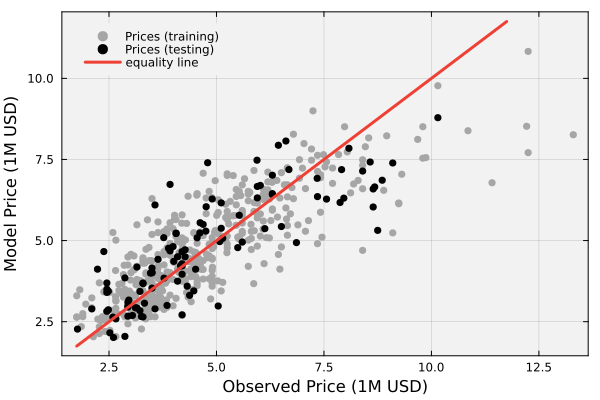

In [11]:
let

    # initialize -
    y_train = training.y;
    ŷ_train = predicted_training_y;
    y_test = testing.y;
    ŷ_test = predicted_testing_y;

    # plot -
    xy_line = min(minimum(ŷ_train), minimum(y_train)):10:max(maximum(y_train),maximum(y_train)) |> collect;
    scatter(y_train,ŷ_train,label="Prices (training)",c=:gray65, msc=:gray65)
    scatter!(y_test,ŷ_test,label="Prices (testing)",c=:black, msc=:black)
    plot!(xy_line,xy_line,lw=3, label="equality line", c=colorant"#EF4035");
   
    xlabel!("Observed Price (1M USD)", fontsize=18)
    ylabel!("Model Price (1M USD)", fontsize=18)
    plot!(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent);
end

## Task 2: Estimate Parameter Confidence Intervals
In this task, let's compute the confidence intervals for the estimated model parameters $\hat{\mathbf{\theta}}$. To do this, we need to compute the standard errors of the parameter estimates $\mathrm{SE}(\hat{\mathbf{\theta}})$, which requires us to estimate the variance of the error terms $\hat{\sigma}^{2}$. 

Let's start there.

> __Theory:__ Since the __true__ variance $\sigma^2$ is unknown, we can estimate the population variance $\hat{\sigma}^2$ from the residuals $\mathbf{r} = \mathbf{y} - \hat{\mathbf{X}}\hat{\mathbf{\theta}}$ as:
> $$
\begin{align*}
\hat{\sigma}^{2} &= \frac{\lVert~\mathbf{r}~\rVert^{2}_{2}}{n-p} = \frac{1}{n-p}\sum_{i=1}^{n}r_i^2
\end{align*}
$$
> where $n$ is the number of observations, $p$ is the number of parameters, $\lVert\star\rVert_{2}^{2}$ denotes the p = 2 norm squared, and $r_i = y_i - \hat{\mathbf{x}}_i^{\top}\hat{\mathbf{\theta}}$ is the $i$-th residual, i.e., the difference between the observed and predicted value for observation $i$.

We implement this computation in the code block below and save the result in the `training_variance::Float64` variable.

In [12]:
training_variance = let

    # initialize -
    y = training.y; # training output
    X = training.X; # training data matrix
    p = length(θ̂₁); # number of parameters
    n = size(X,1); # number of training observations

    # compute the residual -
    r = y .- X*θ̂₁;
    
    # variance -
    my_variance = (1/(n-p))*norm(r)^2

    # let's compute the variance of the residuals (Julia)
    built_in_variance = var(r, corrected=true); # variance - Julia
    @show built_in_variance, my_variance; # show

    my_variance; # return
end;

(built_in_variance, my_variance) = (1.1106831994528121, 1.1421919426997007)


Next, let's compute the standard error. The standard error of the parameter estimates $\hat{\mathbf{\theta}}$ quantifies the uncertainty in the estimated parameters due to the variability in the data. Let's compute the standard error for each parameter $\hat{\theta}_j$ that we estimated in Task 1.

We save the standard errors in the `SE::Vector{Float64}` variable, where element $j$ corresponds to the standard error of a parameter estimate $\text{SE}(\hat{\theta}_j)$.

In [13]:
SE = let
    
    # initialize -
    X = training.X;
    p = length(θ̂₁); # number of parameters
    n = size(X,1); # number of training samples

    # compute the standard error -
    SE = sqrt.(diag(inv(transpose(X)*X))*training_variance);

    SE; # return
end;

Now that we have the standard error for each of the model parameters, we can compute the uncertainty in the parameter estimates $\hat{\mathbf{\theta}}$. Let's compute confidence intervals for each parameter estimate.
> __Confidence Intervals:__ A $(1-\alpha)\times{100}\%$ confidence interval for each parameter $\hat{\theta}_j$ is given by:
> $$
\begin{align*}
\hat{\theta}_j \pm t_{1-\alpha/2,\nu}\; \hat{\sigma}\; \sqrt{\bigl[(\hat{\mathbf X}^\top\hat{\mathbf X})^{-1}\bigr]_{jj}}
\end{align*}
$$
> where $t_{1-\alpha/2,\nu}$ is the $(1-\alpha/2)$-quantile of a Student $t$ distribution with $\nu$ degrees of freedom. For a 95% confidence interval, $\alpha = 0.05$ and $t_{1-\alpha/2,\nu} \approx 1.96$. For a 99.9% confidence interval, $\alpha = 0.001$ and $t_{1-\alpha/2,\nu} \approx 3.291$.

Let's build a table that shows the parameter ranges for a 95.0% confidence interval using [the `PrettyTables.jl` package](https://github.com/ronisbr/PrettyTables.jl). (You can adjust this to show another confidence interval if you like).

In [14]:
let

    # initialize -
    t = 1.96; # for a 95% confidence interval
    df = DataFrame(); # hold the data (rows) for the table

    # build features of the table -
    feature_labels = Array{String,1}();
    names_of_treated_dataset = names(treated_dataset);
    for i ∈ eachindex(names_of_treated_dataset)

        colname = names_of_treated_dataset[i];
        if colname == "t_price"
            continue; # skip the price column
        end
        push!(feature_labels, colname);
    end
    push!(feature_labels, "intercept"); # add the intercept label

    for i ∈ eachindex(θ̂₁)

        center = θ̂₁[i];
        lower_bound = θ̂₁[i] - t*SE[i];
        upper_bound = θ̂₁[i] + t*SE[i];

        row_df = (
            i = i,
            feature = feature_labels[i],
            p = round(center, digits=4),
            l = round(lower_bound, digits=4),
            u = round(upper_bound, digits=4),
            cz = (lower_bound <= 0.0 <= upper_bound ? "yes" : "no")
        ) # data for the row

        push!(df, row_df) # add the row to the dataframe
    end

    # show the table -
    pretty_table(df, backend = :text,
        table_format = TextTableFormat(borders = text_table_borders__simple)) # new table API. Hmmm
end


======== ==================== ========= ========= ========= =========
      i              feature         p         l         u       cz 
  Int64               String   Float64   Float64   Float64   String 
======== ==================== ========= ========= ========= =========
      1             bedrooms    0.1517   -0.0116    0.3151      yes
      2            bathrooms    1.0085    0.7805    1.2365       no
      3              stories     0.442    0.2974    0.5867       no
      4              parking    0.3148    0.1864    0.4432       no
      5           t_mainroad    0.2256    0.0629    0.3882       no
      6          t_guestroom     0.102   -0.0404    0.2445      yes
      7           t_basement    0.1836    0.0628    0.3043       no
      8    t_hotwaterheating    0.3301    0.1047    0.5556       no
      9    t_airconditioning    0.3697      0.25    0.4893       no
     10           t_prefarea    0.3004    0.1754    0.4253       no
     11   t_furnishingstatus    0.2373    

__Analysis:__ Based on the confidence intervals, which parameters are __statistically stable?__ (i.e., which parameters have confidence intervals that do not include zero?) How might this information be useful in refining the model?

> __Key observations:__ Depending on the random data partitioning, some parameters (e.g., number of bedrooms, guest room presence) may have confidence intervals that include zero, indicating they are not statistically significant predictors. This information enables model refinement by identifying features to remove, simplifying the model, improving interpretability, and reducing overfitting while focusing on the key factors that truly influence housing prices.

___

## Task 3: Estimate model parameters with regularization and SVD
In this task, we'll estimate the housing model parameters using Singular Value Decomposition (SVD) with regularization.

There are several types of regularization techniques, but we will focus on __Ridge regression__ (also known as Tikhonov regularization or L2 regularization). The ridge regression problem is given by:
$$
\begin{align*}
\hat{\mathbf{\theta}}_{\delta} = \arg\min_{\mathbf{\theta}}\left( \frac{1}{2}\;\lVert~\mathbf{y} - \hat{\mathbf{X}}\;\mathbf{\theta}~\rVert^{2}_{2} + \frac{\delta}{2}\;\lVert~\mathbf{\theta}~\rVert^{2}_{2}\right)
\end{align*}
$$
where $\delta> 0$ is the regularization parameter controlling regularization strength. The first term measures the sum of squared errors, while the second term penalizes large parameter values. The analytical solution for the optimal parameters is given by:
$$
\begin{align*}
\hat{\mathbf{\theta}}_{\delta} &= \left(\hat{\mathbf{X}}^{\top}\hat{\mathbf{X}} + \delta\;\mathbf{I}\right)^{-1}\hat{\mathbf{X}}^{\top}\mathbf{y}
\end{align*}
$$

Let's start by seting the regularization parameter `δ::Float64`. 

In [69]:
δ = 1000.0; # regularization parameter

Next, let's compute the model parameters directly using the ridge regression formula above. We'll save the model parameters in the `θ̂₂::Vector{Float64}` variable.

In [70]:
θ̂₂ = let

    # initialize -
    X = training.X;
    y = training.y;
    p = size(X,2); # number of parameters

    # compute the ridge regression parameters -
    θ_ridge = inv(transpose(X)*X + δ*I(p))*transpose(X)*y;
    θ_ridge; # return
end;

What are the values of the model parameters `θ₂::Vector{Float64}` compared to the model parameters `θ₁::Vector{Float64}` computed without regularization in Task 1?

In [71]:
let

    # initialize -
    df = DataFrame(); # hold the data (rows) for the table

    # build features of the table -
    feature_labels = Array{String,1}();
    names_of_treated_dataset = names(treated_dataset);
    for i ∈ eachindex(names_of_treated_dataset)

        colname = names_of_treated_dataset[i];
        if colname == "t_price"
            continue; # skip the price column
        end
        push!(feature_labels, colname);
    end
    push!(feature_labels, "intercept"); # add the intercept label

    for i ∈ eachindex(θ̂₂)

        center_1 = θ̂₁[i];
        center_2 = θ̂₂[i];

        row_df = (
            i = i,
            feature = feature_labels[i],
            p1 = round(center_1, digits=4),
            p2 = round(center_2, digits=4),
            Δ  = ((center_2 - center_1)/abs(center_1)) |> x-> round(x, digits=4)
        ) # data for the row

        push!(df, row_df) # add the row to the dataframe
    end

    df
    pretty_table(df, backend = :text,
        table_format = TextTableFormat(borders = text_table_borders__simple)) # new table API. Hmmm
end

======== ==================== ========= ========= ==========
      i              feature        p1        p2         Δ 
  Int64               String   Float64   Float64   Float64 
======== ==================== ========= ========= ==========
      1             bedrooms    0.1517    0.3678    1.4242
      2            bathrooms    1.0085    0.2396   -0.7624
      3              stories     0.442    0.2977   -0.3264
      4              parking    0.3148    0.1412   -0.5515
      5           t_mainroad    0.2256    0.1138   -0.4955
      6          t_guestroom     0.102   -0.0015   -1.0149
      7           t_basement    0.1836    0.0537   -0.7077
      8    t_hotwaterheating    0.3301    -0.067   -1.2029
      9    t_airconditioning    0.3697    0.0895   -0.7578
     10           t_prefarea    0.3004    0.0402   -0.8661
     11   t_furnishingstatus    0.2373    0.0718   -0.6975
     12               t_area    0.2564    0.4542    0.7713
     13            intercept    1.2625    0.1118  

Fill me in here

In [72]:
ϵ_training_regularization = let
    
    # initialize -
    predicted_training_y = training.X * θ̂₂; # predicted output for the training data
    N = length(predicted_training_y);
    y = training.y;
    
    # compute a scaled testing error -
    ϵ = (1/N)*(y .- predicted_training_y)
    ϵ_training = norm(ϵ);

    ϵ_training; # return
end

0.0621617600410684

Fill me in here.

In [73]:
ϵ_test_regularization = let
    
    # initialize -
    predicted_testing_y = testing.X * θ̂₂; # predicted output for the testing data
    N = length(predicted_testing_y);
    y = testing.y;
    
    # compute a scaled testing error -
    ϵ = (1/N)*(y .- predicted_testing_y)
    ϵ_test = norm(ϵ);

    ϵ_test; # return
end

0.1330385289993153

Fill me in here.

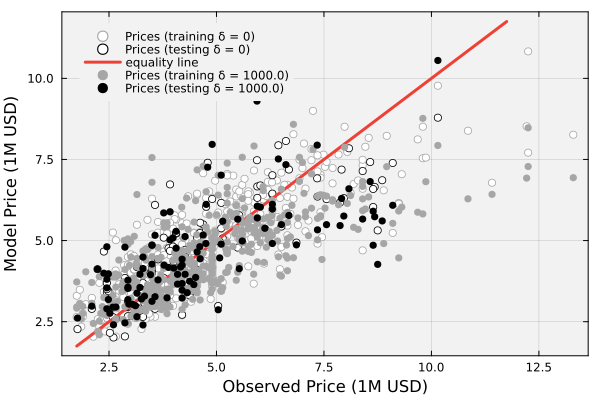

In [74]:
let

    # plot unregularized vs regularized -
    # unregularized -
    y_train = training.y;
    ŷ_train = training.X * θ̂₁;
    y_test = testing.y;
    ŷ_test = testing.X * θ̂₁;

    # plot -
    xy_line = min(minimum(ŷ_train), minimum(y_train)):10:max(maximum(y_train),maximum(y_train)) |> collect;
    scatter(y_train,ŷ_train,label="Prices (training δ = 0)",c=:white, msc=:gray65)
    scatter!(y_test,ŷ_test,label="Prices (testing δ = 0)",c=:white, msc=:black)
    plot!(xy_line,xy_line,lw=3, label="equality line", c=colorant"#EF4035");


    # compute predicted outputs -
    predicted_training_y_reg = training.X * θ̂₂; # predicted output for the training data
    predicted_testing_y_reg = testing.X * θ̂₂; # predicted output for the testing data

    # initialize -
    y_train = training.y;
    ŷ_train = predicted_training_y_reg;
    y_test = testing.y;
    ŷ_test = predicted_testing_y_reg;

    # plot -
    scatter!(y_train,ŷ_train,label="Prices (training δ = $(δ))",c=:gray65, msc=:gray65)
    scatter!(y_test,ŷ_test,label="Prices (testing δ = $(δ))",c=:black, msc=:black)

    xlabel!("Observed Price (1M USD)", fontsize=18)
    ylabel!("Model Price (1M USD)", fontsize=18)
    plot!(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent);
end

## Summary
In this example, we built a linear regression model to predict housing prices using ordinary least squares (OLS) and explored the statistical properties of our parameter estimates through confidence interval analysis.

> __Key Takeaways:__
>
> 1. **OLS parameter estimation works well for overdetermined systems**: Using the normal equations $\hat{\mathbf{\theta}} = (\mathbf{X}^{\top}\mathbf{X})^{-1}\mathbf{X}^{\top}\mathbf{y}$, we successfully estimated model parameters for the housing price dataset. The model showed reasonable predictive performance on both training and testing data, demonstrating its ability to generalize.
> 2. **Confidence intervals reveal feature significance**: By computing standard errors $\mathrm{SE}(\hat{\theta}_j) = \hat{\sigma}\sqrt{[(\mathbf{X}^{\top}\mathbf{X})^{-1}]_{jj}}$ and 95% confidence intervals, we identified which features are statistically significant predictors of housing prices. Parameters with confidence intervals that include zero (e.g., number of bedrooms, guest room presence) may not contribute meaningfully to the model.
> 3. **Statistical inference guides model refinement**: Understanding parameter uncertainty enables data-driven decisions about feature selection and model simplification. Removing statistically insignificant features can improve model interpretability, reduce overfitting, and help identify the key factors that truly influence housing prices in real estate applications.

This practical application demonstrates how the mathematical foundations from the lecture translate into real-world data analysis, where understanding both point estimates and their uncertainty is crucial for building reliable predictive models.
___